# BAF627 HW1

20249433 최재필

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import scipy.optimize as sco

from tqdm import tqdm

In [2]:
np.random.seed(42)

In [3]:
CWD = Path.cwd()
OUTPUT_PATH = CWD / 'output'

## 0. Import Data

### Load data & convert

In [4]:
msf = pd.read_csv('msf.csv')
msp500_rf = pd.read_csv('msp500_risk_free.csv')

In [5]:
# datetime index
msf['mdate'] = pd.to_datetime(msf['mdate'])
msp500_rf['mdate'] = pd.to_datetime(msp500_rf['mdate'])

In [6]:
msf_ret_df = msf[['mdate', 'ticker', 'ret']].pivot(index='mdate', columns='ticker', values='ret')
sp500_ret_s = msp500_rf[['mdate', 'spret']].set_index('mdate')
rf_s = msp500_rf[['mdate', 'rf']].set_index('mdate')

sp500_excess_s = sp500_ret_s['spret'] - rf_s['rf']
msf_excess_df = msf_ret_df.subtract(rf_s['rf'], axis=0)

### Basic matrix/vectors

In [7]:
# Pandas
cov_df = msf_ret_df.cov()
excess_cov_df = msf_excess_df.cov()
mean_ret_s = msf_ret_df.mean()
mean_excess_s = msf_excess_df.mean()
std_s = msf_ret_df.std()

# Numpy
cov_2d = cov_df.values
excess_cov_2d = excess_cov_df.values
mean_ret_v = mean_ret_s.values
mean_excess_v = mean_excess_s.values
std_v = std_s.values

sp500_ret_v = sp500_ret_s.values
sp500_excess_v = sp500_excess_s.values
rf_v = rf_s.values

In [8]:
sid_list = mean_ret_s.index
date_list = msf_ret_df.index

### Basic scalar

In [9]:
mean_ret = mean_ret_v.mean()
mean_excess = mean_excess_v.mean()

sp500_ret = sp500_ret_v.mean()
sp500_std = sp500_ret_v.std()
sp500_excess = sp500_excess_v.mean()
sp500_excess_std = sp500_excess_v.std()

rf = rf_v.mean()

## 1. No risk-free & Short-selling allowed

Case #2

### (a)

- Derive the mean-variance frontier using the standard deviation for measuring risk
- Plot the mean-variance frontier
- Indicate the global minimum portfolio (GMVP) on the plot

In [10]:
def get_port_mean(W, mean_v, rf_v=None):
    if rf_v:
        return np.dot(W, mean_v - rf_v)
    else:
        return np.dot(W, mean_v)

In [11]:
def get_port_var(W, cov_2d):
    return np.dot(W.T, np.dot(cov_2d, W))

In [12]:
def negative_port_sharpe(W, mean_v, cov_2d, rf_v=None):
    port_mean = get_port_mean(W, mean_v, rf_v)
    port_var = get_port_var(W, cov_2d)
    port_std = np.sqrt(port_var)

    if port_mean > 0:
        return -port_mean / port_std
    else:
        return port_mean / port_std

In [13]:
def optimize_portfolio(mean_v, cov_2d):
    n = len(mean_v)
    args = (mean_v, cov_2d)
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
        ]
    bounds = tuple((-1, 1) for i in range(n))

    result = sco.minimize(
        negative_port_sharpe,
        n * [1. / n,],
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )

    return result

In [14]:
def optimize_portfolio_given_return(target_return, mean_v, cov_2d, rf_v=None):
    n = len(mean_v)
    args = (mean_v, cov_2d, rf_v)
    constraints = [
        {'type': 'eq', 'fun': lambda W: np.sum(W) - 1},
        {'type': 'eq', 'fun': lambda W: target_return - get_port_mean(W, mean_v, rf_v)},
        ]
    bounds = tuple((-1, 1) for i in range(n))

    result = sco.minimize(
        negative_port_sharpe,
        n * [1. / n,],
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
    )

    return result

In [15]:
def get_efficient_frontier(mean_v, cov_2d, rf_v=None, return_minmax=[-0.1, 0.1], num_portfolios=100):
    weights_record = []

    min_return, max_return = return_minmax
    ret_range = np.linspace(min_return, max_return, num_portfolios)
    frontier_ports = np.zeros((3, len(ret_range))) # mean, std, sharpe

    for i, target_return in enumerate(tqdm(ret_range)):
        result = optimize_portfolio_given_return(target_return, mean_v, cov_2d, rf_v)
        weights = result.x

        port_mean = get_port_mean(weights, mean_v, rf_v)
        port_std = np.sqrt(get_port_var(weights, cov_2d))

        frontier_ports[0, i] = port_mean
        frontier_ports[1, i] = port_std
        frontier_ports[2, i] = port_mean / port_std

        weights_record.append(weights)

    return frontier_ports, weights_record

In [16]:
Q1_frontier_ports, Q1_weights_record = get_efficient_frontier(mean_excess_v, cov_2d, num_portfolios=100)

100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


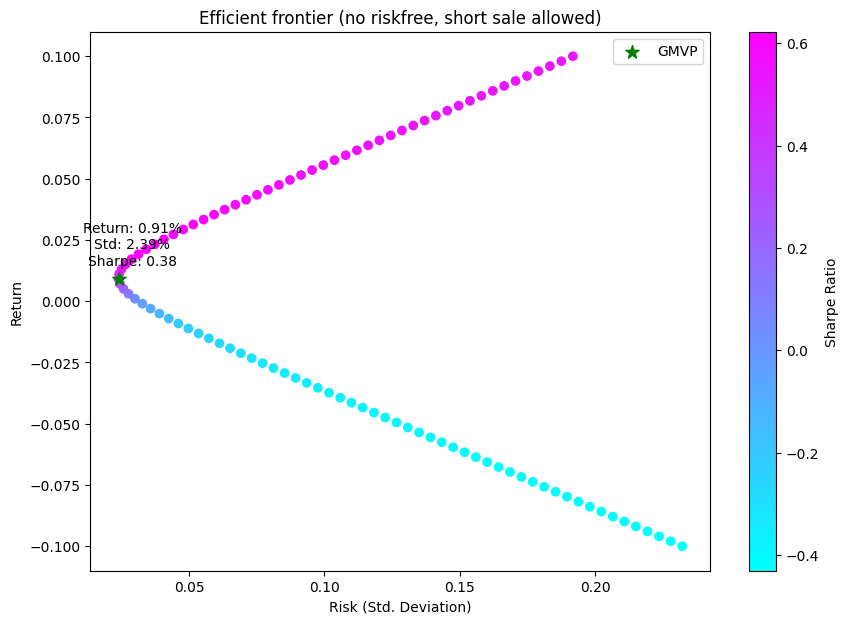

In [17]:
# Global minimum variance portfolio
min_vol_idx = np.argmin(Q1_frontier_ports[1])
gmvp_ret, gmvp_std, gmvp_sharpe = Q1_frontier_ports[:, min_vol_idx]

# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(Q1_frontier_ports[1, :], Q1_frontier_ports[0, :], c=Q1_frontier_ports[2, :], cmap='cool', marker='o')
plt.colorbar(label='Sharpe Ratio')

plt.scatter(gmvp_std, gmvp_ret, marker='*', color='g', s=100, label='GMVP')

plt.title('Efficient frontier (no riskfree, short sale allowed)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)

plt.annotate(
    f'Return: {gmvp_ret:.2%}\nStd: {gmvp_std:.2%}\nSharpe: {gmvp_sharpe:.2f}',
    (gmvp_std, gmvp_ret),
    textcoords='offset points',
    xytext=(10, 10),
    ha='center'
)

plt.show()

### (b)

- Derive optimal portfolio weights that matches S&P500 BM return
- Report portfolio weights in an excel file
- Report portfolio weights on a given set of stocks

In [18]:
sp500_ret

0.007691879732135416

In [19]:
Q1_match_sp500_result = optimize_portfolio_given_return(sp500_ret, mean_ret_v, cov_2d)
Q1_match_sp500_weights = Q1_match_sp500_result.x

Q1_match_sp500_weights_df = pd.DataFrame(Q1_match_sp500_weights, index=sid_list, columns=['weight'])
Q1_match_sp500_weights_df

,weight
ticker,
AAPL,-0.001531
ABT,0.033021
ADBE,-0.011211
ADI,-0.006286
ADP,-0.000268
...,...
VZ,-0.019541
WFC,-0.047710
WM,0.004380


In [20]:
Q1_match_sp500_weights_df.to_csv(OUTPUT_PATH / 'hw1_1.b_match_sp500_weights.csv')

In [21]:
WATCH_LIST = ['MMM', 'BAC', 'AMD', 'AAPL', 'MCD']

Q1_match_sp500_weights_df.loc[WATCH_LIST]

,weight
ticker,
MMM,0.137152
BAC,-0.017789
AMD,-0.024176
AAPL,-0.001531
MCD,-0.003986


### (c)

- Compute the annualized excess returns, annualized volatility, and annualized Sharpe ratio of the optimal (matching) portfolio and S&P500 BM

In [22]:
sp500_excess_annual = sp500_excess * 12
sp500_excess_std_annual = sp500_excess_std * np.sqrt(12)
sp500_sharpe = sp500_excess_annual / sp500_excess_std_annual

sp500_excess_annual, sp500_excess_std_annual, sp500_sharpe

(0.06700255678562506, 0.14584236192180058, 0.45941766097803083)

In [23]:
Q1_optimal_ret_s = msf_ret_df.multiply(Q1_match_sp500_weights, axis=1).sum(axis=1)
Q1_optimal_excess_s = Q1_optimal_ret_s - rf_s['rf']

Q1_optimal_excess = Q1_optimal_excess_s.mean()
Q1_optimal_excess_std = Q1_optimal_excess_s.std()

Q1_optimal_excess_annual = Q1_optimal_excess * 12
Q1_optimal_excess_std_annual = Q1_optimal_excess_std * np.sqrt(12)
Q1_optimal_sharpe = Q1_optimal_excess_annual / Q1_optimal_excess_std_annual

Q1_optimal_excess_annual, Q1_optimal_excess_std_annual, Q1_optimal_sharpe

(0.06700255678551453, 0.08799755612671221, 0.7614138361869288)

### (d)

- Plot the cumulative return of optimal and S&P500
- Discuss the difference in the performance of the two

In [24]:
def get_cumreturn(ret_s):
    return (1 + ret_s).cumprod() - 1

In [25]:
sp500_cumret_s = get_cumreturn(sp500_ret_s)
optimal_cumret_s = get_cumreturn(Q1_optimal_ret_s)

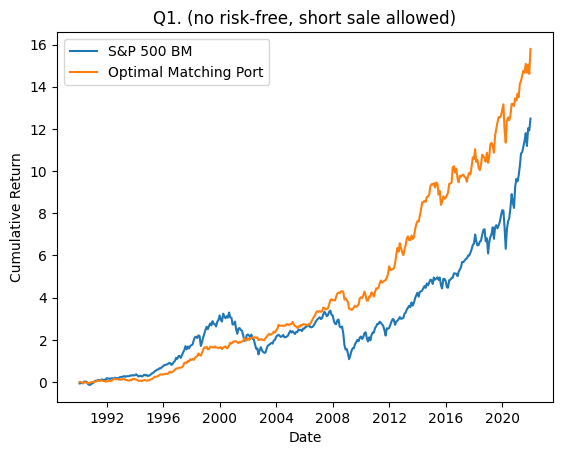

In [26]:
# Plot S&P 500 cumulative return
plt.plot(sp500_cumret_s, label='S&P 500 BM')

# Plot optimal matching portfolio cumulative return
plt.plot(optimal_cumret_s, label='Optimal Matching Port')

# Add title and labels
plt.title('Q1. (no risk-free, short sale allowed)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

# Add legend
plt.legend()

# Show plot
plt.show()

## 2. There is risk-free & Short-selling allowed

Case #1

### (a)

- Derive the MV frontier
- Report the slop of the MV frontier
- Plot the MV frontier together with the MV frontier in Q1

In [32]:
Q2_tangent_point = (None, None) # std, ret
tangent_point_index = None

current_maximum_sharpe = -np.inf
for i in range(Q1_frontier_ports.shape[1]): # From lowest to the highest return
    ret = Q1_frontier_ports[0, i]
    std = Q1_frontier_ports[1, i]
    
    current_sharpe = (ret - rf) / std
    if current_sharpe > current_maximum_sharpe:
        current_maximum_sharpe = current_sharpe
        Q2_tangent_point = (std, ret)
        tangent_point_index = i
    
    if current_sharpe < current_maximum_sharpe:
        break

In [33]:
Q2_tangent_sharpe = current_maximum_sharpe
Q2_tangent_sharpe # Slope

0.5696513987239219

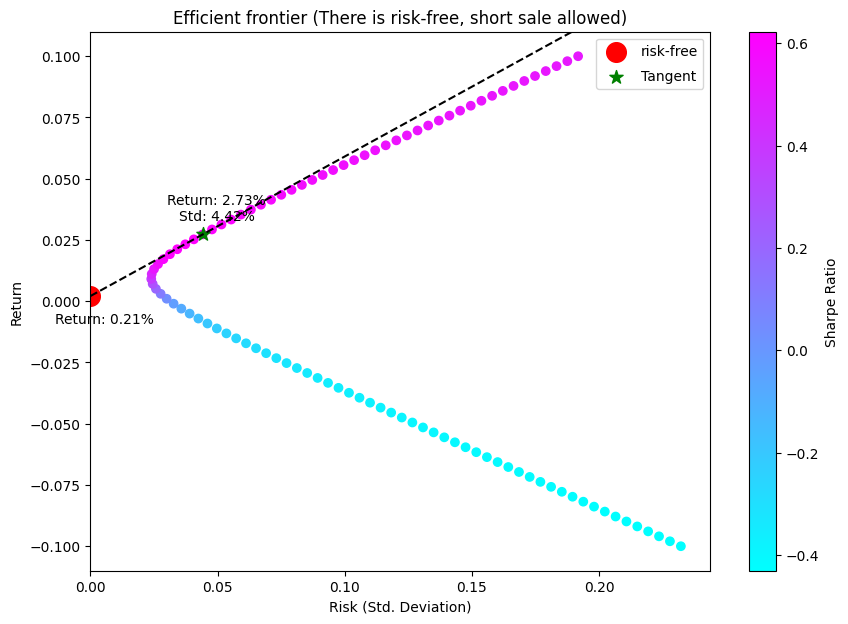

In [35]:
# Plot efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(Q1_frontier_ports[1, :], Q1_frontier_ports[0, :], c=Q1_frontier_ports[2, :], cmap='cool', marker='o')
plt.colorbar(label='Sharpe Ratio')

# Plot risk-free point
plt.scatter(0, rf, marker='o', color='r', s=200, label='risk-free')

# Plot tangent point
plt.scatter(*Q2_tangent_point, marker='*', color='g', s=100, label='Tangent')

# Draw the Capital Market Line (CML)
plt.axline(
    (0, rf), 
    slope=(Q2_tangent_point[1] - rf) / Q2_tangent_point[0], 
    color='black', 
    linestyle='--', 
    linewidth=1.5,
)

# Add title and labels
plt.title('Efficient frontier (There is risk-free, short sale allowed)')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.xlim(left=0)

# Annotate risk-free point
plt.annotate(
    f'Return: {rf:.2%}',
    (0, rf),
    textcoords='offset points',
    xytext=(10, -20),  # Adjust position to avoid overlap
    ha='center'
)

# Annotate tangent point
plt.annotate(
    f'Return: {Q2_tangent_point[1]:.2%}\nStd: {Q2_tangent_point[0]:.2%}',
    Q2_tangent_point,
    textcoords='offset points',
    xytext=(10, 10),  # Adjust position to avoid overlap
    ha='center'
)

# Show plot
plt.show()


### (b)

- Derive optimal portfolio weights that matches S&P500 BM return
- Report portfolio weights in an excel file
- Report portfolio weights on a given set of stocks
- Report the weight of a risk-free asset

In [36]:
Q2_tangent_ret, Q2_tangent_std = Q2_tangent_point
Q2_tangent_ret, Q2_tangent_std

(0.0441750761882383, 0.027272727272699093)

In [31]:
sp500_sharpe

0.45941766097803083

In [37]:
Q2_match_sp500_std = (sp500_ret - rf) / Q2_tangent_sharpe
Q2_match_sp500_std

0.009801689965669897

In [38]:
Q2_risky_weight = (sp500_ret - rf) / (Q2_tangent_ret - rf)
Q2_riskfree_weight = 1 - Q2_risky_weight

Q2_risky_weight, Q2_riskfree_weight

(0.1327306565678414, 0.8672693434321586)

In [39]:
Q2_port_weights = Q2_risky_weight * Q1_match_sp500_weights

Q2_port_weights_df = pd.DataFrame(Q2_port_weights, index=sid_list, columns=['weight'])
Q2_port_weights_df

,weight
ticker,
AAPL,-0.000203
ABT,0.004383
ADBE,-0.001488
ADI,-0.000834
ADP,-0.000036
...,...
VZ,-0.002594
WFC,-0.006333
WM,0.000581


In [41]:
Q2_port_weights_df.to_csv(OUTPUT_PATH / 'hw1_2.b_port_weights.csv')

In [40]:
Q2_port_weights_df.loc[WATCH_LIST]

,weight
ticker,
MMM,0.018204
BAC,-0.002361
AMD,-0.003209
AAPL,-0.000203
MCD,-0.000529


### (c)

- Compute the annualized excess returns, annualized volatility, and annualized Sharpe ratio of the optimal (matching) portfolio and S&P500 BM
- Compare the result from Q1

### (d)

- Plot the cumulative return of optimal and S&P500 (with previous results)
- Discuss the difference in the performance of the three portfolios